In [1]:
import numpy as np
from numpy import array,zeros,vstack,repeat,ones,eye,ndarray
from cvxopt import *
import pylab as pl

# So let's talk about the SVM$_\Delta$+

The SVM$_\Delta$+ is a varient on the standard SVM and is written about in [this paper](http://www.jmlr.org/papers/volume16/vapnik15b/vapnik15b.pdf), where instead of just accepting input $X$, and output $Y$, the classifier also has access to extra privileged information $X*$ at training time, but crucially, not at any point past then. So when we come to making predictions, we'll be making them based solely on data looks a lot like $X$. (Quick note, $X*$ doesn't have to be in the same feature space as $X$).

So, some things we're gonna need. Just gonna blast through these at the top because then they're done and out of the way.

We need a data generator as we're going to use toy data (for now)

In [2]:
# Generates 2D data that is largely linearly separable, but overlaps slightly
def gen_lin_separable_overlap_data(n):
    mean1 = np.array([0, 1])
    mean2 = np.array([1, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, (n//2))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, (n//2))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

# Generates 2D data that is linearly separable - no overlap
def gen_lin_separable_data(n):
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, (n//2))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, (n//2))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

And we're also going to need a way of visualising this data.

In [3]:
def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro", label="Class +1")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo", label="Class -1")
    pl.scatter(clf.support_vectors[:,0], clf.support_vectors[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -5; a1 = f(a0, clf.w, clf.b)
    b0 = 5; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -5; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 5; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -5; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 5; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.xlabel('x1')
    pl.ylabel('x2')

    #pl.legend(numpoints=1)

    #pl.axis("tight")
    pl.show()

Ignore this bit, it's so we can have different kernels on our data... It shouldn't make a difference for now.

In [4]:
class Linear():
    def __call__(self, a, b):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return np.dot(x, y)

class Polynomial():
    def __call__(self, a, b, p=3):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return (1 + np.dot(x, y)) ** p

class Gaussian():
    def __call__(self, a, b, sigma=5.0):
        x = np.array(a)
        y = np.array(b)
        y = np.transpose(y)
        return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

And we're going to create a "problem" class. This is just somewhere where we keep the data that we're training the SVM on, but it also holds some hyperparameters that we might need later on.

In [5]:
class svm_problem():
    def __init__(self, C=1.0, gamma=1.0, delta=1.1, kernel=Linear()):
        self.C = C
        self.gamma = gamma
        self.delta = delta
        self.kernel = kernel

    def set_variables(self, X, Xstar, Y):
        if(isinstance(X, ndarray)):
            self.X = X
        else:
            self.X = array(X)
        if(isinstance(Xstar, ndarray)):
            self.Xstar = Xstar
        else:
            self.Xstar = array(Xstar)
        if(isinstance(Y, ndarray)):
            self.Y = Y
        else:
            self.Y = array(Y)
        self.num = len(self.X)
        self.dimensions = len(self.X[0])
        self.xi_xj = self.gram_matrix(self.X, self.X)
        self.xstari_xstarj = self.gram_matrix(self.Xstar, self.Xstar)
        self.xstari_xj = self.gram_matrix(self.Xstar, self.X)
        self.yi_yj = self.gram_matrix(self.Y, self.Y)

    def gram_matrix(self, X1, X2):
        K = zeros((len(X1), len(X1)))
        for i in range(len(X1)):
            for j in range(len(X1)):
                K[i,j] = self.kernel(X1[i], X2[j])
        return K

Sweet, so what is it that we're solving?

The regular SVM looks like this. We want to
$$\begin{equation}
\begin{aligned}
\min_{\textbf{w},b,\xi} \quad & \frac{1}{2}||\textbf{w}||^2 + C\sum_{i=1}^{\ell}\xi_i\\
\textrm{subject to} & \quad y_i(\textbf{w} \cdot \textbf{x}_i+b)\geq 1 - \xi_i \\
\textrm{and} & \quad \xi_i \geq 0
\end{aligned}
\end{equation}$$
Meaning we want to make the maergin as wide as possible in our classifier, but we're going to be penalised for every breach of that margin. So, breaches are allowed, but they cost.

Turns out this is actually quite hard to solve as the conditions are quite complex. If we change this to it's dual 
$$\begin{equation}
\begin{aligned}
\max_{\alpha} \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2} & \sum_{i,j=1}^{\ell}\alpha_i \alpha_j y_i y_j (\textbf{x}_i \cdot \textbf{x}_j) \\
\textrm{subject to} & \quad 0 < \alpha_i < C \\
\textrm{and} & \quad \sum_{i=1}^{m} \alpha_i y_i = 0
\end{aligned}
\end{equation}$$
We get a convex optimisation problem that can be solved using such convex optimisation tools as CVXOPT.

CVXOPT solves problems in the following format
$$\begin{equation}
\begin{aligned}
\min_{x} \quad & \frac{1}{2}x^TPx+q^Tx \\
\textrm{subject to} \quad & Gx \leq h \\
\textrm{and} \quad & Ax = b
\end{aligned}
\end{equation}$$

which as you can see is sort of the same shape as the dual form of the SVM problem. But instead of minimising over $x$ we want to maximise over $/alpha$. Doing this is easy enough. We just have to do a bit of rearranging, giving us
$$\begin{equation}
\begin{aligned}
\min_{\alpha} & \quad \frac{1}{2} \sum_{i,j=1}^{\ell}\alpha_i (y_i y_j (\textbf{x}_i \cdot \textbf{x}_j)) \alpha_j - \sum_{i=1}^{\ell}\alpha_i \\
\textrm{subject to} & \quad -\alpha_i < 0 \\
\textrm{and} & \quad \alpha_i < C \\
\textrm{and} & \quad \sum_{i=1}^{m} \alpha_i y_i = 0
\end{aligned}
\end{equation}$$

To form P we make a Gram Matrix of $Y$ and a second of $X$ then multiply them together 
$$\begin{equation}
P = 
\begin{pmatrix} y_1y_1(\textbf{x}_1\textbf{x}_1) & \cdots & y_iy_1(\textbf{x}_i\textbf{x}_1)\\
\vdots & \ddots & \vdots \\
y_1y_j(\textbf{x}_1\textbf{x}_j) & \cdots & y_iy_j(\textbf{x}_i\textbf{x}_j)
\end{pmatrix} 
\end{equation}$$

q is the negative identity matrix $$\begin{equation}
q = 
\begin{pmatrix} -1 & 0 & \cdots & 0 \\
0 & -1 & \cdots & 0 \\
\vdots & \cdots & \ddots & \vdots \\
0 & \cdots & 0 & -1
\end{pmatrix} 
\end{equation}$$

G and h are slightly more tricky as we've got two less than statements, but let's break them down and talk about G1 and h1 being $0\leq\alpha_i$ and G2 and h2 being $\alpha_i\leq C$

$\begin{equation}
G1 = 
\begin{pmatrix} -1 & 0 & \cdots & 0 \\
0 & -1 & \cdots & 0 \\
\vdots & \cdots & \ddots & \vdots \\
0 & \cdots & 0 & -1
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h1 = 
\begin{pmatrix} 0_1 \\
0_2 \\
\vdots \\
0_n
\end{pmatrix} 
\end{equation}$

$-1\times\alpha_1\leq 0 \cdots -1\times\alpha_n\leq 0$

$\begin{equation}
G2 = 
\begin{pmatrix} 1 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0 \\
\vdots & \cdots & \ddots & \vdots \\
0 & \cdots & 0 & 1
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h2 = 
\begin{pmatrix} C_1 \\
C_2 \\
\vdots \\
C_n
\end{pmatrix} 
\end{equation}$
C is a constant, so $C_n$ means the $n^{th}$ repitition of C

Then we stack them so that $\begin{equation}
G = 
\begin{pmatrix} G1 \\
G2
\end{pmatrix} 
\end{equation}$
and $\begin{equation}
h = 
\begin{pmatrix} h1 \\
h2
\end{pmatrix} 
\end{equation}$ Don't think this is some clever notation. I literally mean G1 stacked on top of G2. Same with h.

$\begin{equation}
A = 
\begin{pmatrix} y_1 & y_2 & \cdots & y_n
\end{pmatrix} 
\end{equation}$ $\begin{equation}
b = 
\begin{pmatrix} 0
\end{pmatrix} 
\end{equation}$

Notice that A is a vector, not a column matrix. This is because we want the sum of $\alpha y$ to be 0, not element-wise

So now lets go ahead and put this in a solver. This might be a bit dull, but first we're going to generate some data. $X$ is going to have some overlap, but the privileged data will be separable. As at the moment we're just looking at the regular SVM, we'll ignore the $X*$ data.

In [6]:
x1, y1, x2, y2 = gen_lin_separable_overlap_data(60)
X = np.vstack((x1,x2))
Y = np.hstack((y1,y2))
x3,y1,x4,y2 = gen_lin_separable_data(60)
Xstar = np.vstack((x3,x4))

prob = svm_problem(C=1.0)
prob.set_variables(X, Xstar, Y)

In [7]:
x = prob.X
y = prob.Y
C = prob.C

NUM = x.shape[0]
DIM = x.shape[1]

Ky = prob.yi_yj
Kx = prob.xi_xj
K = Ky*Kx
P = matrix(K, tc='d')
q = matrix(-np.ones((NUM, 1)), tc='d')
G1 = -np.eye(NUM)
G2 = np.eye(NUM)
G = np.vstack((G1, G2))
G = matrix(G, tc='d')
h1 = np.zeros(NUM).reshape(-1,1)
h2 = np.repeat(C, NUM).reshape(-1,1)
h = np.vstack((h1, h2))
h = matrix(h, tc='d')
A = matrix(y.reshape(1, -1), tc='d')
b = matrix(np.zeros(1), tc='d')
solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

If you print out alphas, you should get an array of values that are proactiaclly 0, except for the supprt vectors. They're slightly bigger than 0. Depending on the hyperparameters, there should be very few of them.

So having the alphas is great, but we want to extract weights and bias to make a prediction... So lets do that now.

$$\textbf{w} = \sum_{i=1}^{L}\alpha_iy_i\textbf{x}_i$$

In [8]:
w = np.sum(alphas * y[:, None] * x, axis = 0)

The bias is a bit trickier. We need to get the set of support vectors ($S$) that match $0<\alpha_i\leq C$ then solve

$$b = \frac{\sum_{s=1}^{S}(y_s-\sum_{m=1}^{S}\alpha_my_m(\textbf{x}_m\cdot\textbf{x}_s))}{\textrm{Number of S}}$$

As you might imagine, this is a bit of a faff, but below does the trick

In [9]:
bacond1 = (alphas > 1e-5)
bdcond2 = (alphas < C)

bcond = np.array([a and b for a, b in zip(bacond1, bdcond2)]).flatten()

yS = y[bcond]
xS = x[bcond]
aS = alphas[bcond]


sumTotal = 0
for s in range(len(yS)):
    innerTotal = 0
    for m in range(len(yS)):
        am = aS[m]
        ym = yS[m]
        xm_xs = prob.kernel(xS[m], xS[s])
        innerTotal += am*ym*xm_xs
    sumTotal += yS[s] - innerTotal

bias = sumTotal/len(yS)

Then we put this in a a dull, but useful class called classifier, just to keep everything neat and out of the way.

In [10]:
class classifier():

    def __init__(self):
        self.w = 0
        self.b = 0
        self.alphas = []
        self.support_vectors = []

    def predict(self, x):
        return np.sign(np.dot(self.w,x)+self.b)
    
    def f_star(self, x, y): # This won't make sense now, but we come back to it later
        return y*(np.dot(self.w,x)+self.b)

In [11]:
svm_clf = classifier()
svm_clf.w = w
svm_clf.b = bias
svm_clf.alphas = alphas
svm_clf.support_vectors = prob.X[bacond1.flatten()]

And that's it.... a trained SVM. Shall we take a look at it?

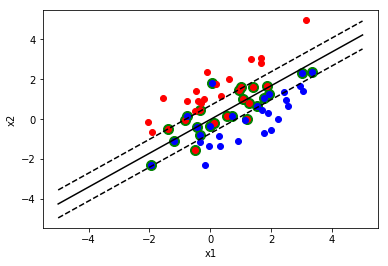

In [12]:
plot_margin(prob.X[y==1], prob.X[y==-1], svm_clf)

Which is all a bit sexy. Go back to the problem definition and play with the C value. the bigge then number (like 10?), the harder the margin, the lower (say, 0.01), the softer.

BUT WHAT DOES THIS HAVE TO DO WITH SVM$_\Delta$+? Everything. There are two versions, a simplified approach and a non-simplified approach. Let's break them down. But first I'm just going to put the above in a class just so that it's eaiser if we want to use it in the future.

In [13]:
class SVM():
    def train(self, x, prob : svm_problem):
        self.x = x
        self.y = prob.Y
        self.C = prob.C

        self.NUM = self.x.shape[0]

        K = self.y[:, None] * self.x # Yeah, this is a bit different so that it can work on x and x*
        K = np.dot(K, K.T)
        P = matrix(K, tc='d')
        q = matrix(-np.ones((self.NUM, 1)), tc='d')
        G1 = -np.eye(self.NUM)
        G2 = np.eye(self.NUM)
        G = np.vstack((G1, G2))
        G = matrix(G, tc='d')
        h1 = np.zeros(self.NUM).reshape(-1,1)
        h2 = np.repeat(self.C, self.NUM).reshape(-1,1)
        h = np.vstack((h1, h2))
        h = matrix(h, tc='d')
        A = matrix(self.y.reshape(1, -1), tc='d')
        b = matrix(np.zeros(1), tc='d')
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bacond1 = (self.alphas > 1e-5)
        bacond2 = (self.alphas < (self.C))
        bcond = np.array([a and b for a, b in zip(bacond1, bacond2)]).flatten()
        yS = self.y[bcond]
        xS = self.x[bcond]
        aS = self.alphas[bcond]
        sumTotal = 0
        for s in range(len(yS)):
            innerTotal = 0
            for m in range(len(yS)):
                am = aS[m]
                ym = yS[m]
                xm_xs = prob.kernel(xS[m], xS[s])
                innerTotal += am*ym*xm_xs
            sumTotal += yS[s] - innerTotal
        bias = sumTotal/len(yS)
        clf = classifier()
        clf.w = w
        clf.b = bias[0]
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond1.flatten()]
        return clf

In [14]:
svm = SVM()
svm_clf = svm.train(prob.X, prob)

## SVM$_\Delta$+ - The simplified approach

The simplified approach uses the SVM we've already written. If you want to see this on the paper we're following, it's [page 2034](http://www.jmlr.org/papers/volume16/vapnik15b/vapnik15b.pdf "Vapnik paper"). Firstly we learn an SVM in the privileged space $X*$

In [15]:
svm = SVM()
xStar_clf = svm.train(prob.Xstar, prob)

Then we use this to work out a set of slack values in the privileged space $\xi^* = [1-f^*(x^*,\alpha^*)-b^*]_+$ where $f^*(x^*,\alpha^*)=\sum_{i=1}^{\ell}\alpha_i^*(x_i^*,x)+b^*$. This means we choose the highest value of 0 or the predicted value. But let's be honest, that looks tricky and we know what we want, the predicted value $(w,x)+b$, so as we've got the $w$ already, let's just do that.

In [16]:
xi_star = np.zeros(prob.num)
for i in range(prob.num):
    output = (1- prob.Y[i]*(np.dot(xStar_clf.w,prob.Xstar[i])+xStar_clf.b) - xStar_clf.b)
    xi_star[i] = max(0, output)

So if we were to look at the $X*$ classifier on a graph, we should see that there aren't really any breaches as we've used a linearly seperable set of data for $X*$, consequently, the values of $\xi^*$ should also all be almost 0 (except the ones that breach the margin).

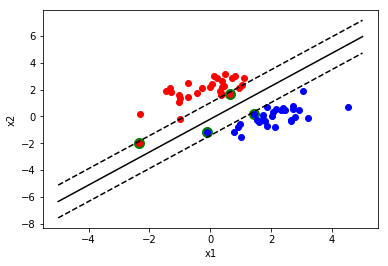

In [17]:
plot_margin(prob.Xstar[y==1], prob.Xstar[y==-1], xStar_clf)

Looking at the above, I think the $-b^*$ in $\xi^* = [1-f^*(x^*,\alpha^*)-b^*]_+$ isn't needed. The $b^*$ is part of predicting where it lies, why would we take this value off after just adding it on? And if we have it, we're not taking into account the bias in any predictions.

Look at the graph above, then the values of xi_star below and decide which you think is a better representation of the slack values?

In [18]:
xi_star_amended = np.zeros(prob.num)
for i in range(prob.num):
    output = (1- prob.Y[i]*(np.dot(xStar_clf.w,prob.Xstar[i])+xStar_clf.b))
    xi_star_amended[i] = max(0, output)

In [19]:
xi_star, xi_star_amended

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.13521928,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

we then basically train another SVM. This time though, instead of using exactly the same model as before, we have to do a different one as there are different constraints. Let's look at them. 
$$\begin{equation}
\begin{aligned}
\max_{\alpha} \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2} & \sum_{i,j=1}^{\ell}\alpha_i \alpha_j y_i y_j (\textbf{x}_i \cdot \textbf{x}_j) \\
\textrm{subject to} & \quad \sum_{i=1}^{\ell}\alpha_i\xi^*_i \leq C\sum_{i=1}^{\ell}\xi^*_i \\
\textrm{and} & \quad 0 < \alpha_i < (1+\Delta)C \\
\textrm{and} & \quad \sum_{i=1}^{m} \alpha_i y_i = 0
\end{aligned}
\end{equation}$$

So let's break it down. The main optimisation problem is the same as a regular SVM, so we can use the same P and q as before. The equality constraint is the same, so we have the same A and b. We just need a new G and h. Let's break it down. G1 and h1 give $-\alpha\leq0$, G2 and h2 $\alpha\leq(1+\Delta)C$ and G3 and h3 being $\sum_{i=1}^{\ell}\alpha_i\xi^*_i \leq C\sum_{i=1}^{\ell}\xi^*_i$

$\begin{equation}
G1 = 
\begin{pmatrix} -1 & 0 & \cdots & 0 \\
0 & -1 & \cdots & 0 \\
\vdots & \cdots & \ddots & \vdots \\
0 & \cdots & 0 & -1_n
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h1 = 
\begin{pmatrix} 0_1 \\
0_2 \\
\vdots \\
0_n
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G2 = 
\begin{pmatrix} 1 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0 \\
\vdots & \cdots & \ddots & \vdots \\
0 & \cdots & 0 & 1_n
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h2 = 
\begin{pmatrix} (1+\Delta)C_1 \\
(1+\Delta)C_2 \\
\vdots \\
(1+\Delta)C_n
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G3 = 
\begin{pmatrix} \xi_1^* & \xi_2^* & \cdots & \xi_n^*
\end{pmatrix} 
\end{equation}$ $\begin{equation}
h3 = 
\begin{pmatrix} C\sum_{i=1}^{\ell}\xi_i^*
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G = 
\begin{pmatrix} G1 \\
G2 \\
G3
\end{pmatrix} 
\end{equation}$
and $\begin{equation}
h = 
\begin{pmatrix} h1 \\
h2 \\
h3
\end{pmatrix} 
\end{equation}$

In [20]:
x = prob.X
y = prob.Y
C = prob.C

NUM = x.shape[0]
DIM = x.shape[1]

Ky = prob.yi_yj
Kx = prob.xi_xj
K = Ky*Kx
P = matrix(K, tc='d')
q = matrix(-np.ones((NUM, 1)), tc='d')
G1 = -np.eye(NUM)
G2 = np.eye(NUM)
G3 = xi_star_amended.reshape(1,-1)
G = np.vstack((G1, G2))
G = np.vstack((G, G3))
G = matrix(G, tc='d')
h1 = np.zeros(NUM).reshape(-1,1)
h2 = np.repeat(C, NUM).reshape(-1,1)
h3 = sum(xi_star_amended)*C
h = np.vstack((h1, h2))
h = np.vstack((h, h3))
h = matrix(h, tc='d')
A = matrix(y.reshape(1, -1), tc='d')
b = matrix(np.zeros(1), tc='d')
solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

In [21]:
w = np.sum(alphas * y[:, None] * x, axis = 0)

bacond1 = (alphas > 1e-5)
bacond2 = (alphas < C)
bcond = np.array([a and b for a, b in zip(bacond1, bacond2)]).flatten()

yS = y[bcond]
xS = x[bcond]
aS = alphas[bcond]

sumTotal = 0
for s in range(len(yS)):
    innerTotal = 0
    for m in range(len(yS)):
        am = aS[m]
        ym = yS[m]
        xm_xs = prob.kernel(xS[m], xS[s])
        innerTotal += am*ym*xm_xs
    sumTotal += yS[s] - innerTotal

bias = sumTotal/len(yS)

svmdpsa_clf = classifier() # svmdpsa means svm delta plus simplified approach
svmdpsa_clf.w = w
svmdpsa_clf.b = bias
svmdpsa_clf.alphas = alphas
svmdpsa_clf.support_vectors = prob.X[bacond1.flatten()]

Let's check it out! We'll put it all in one class, then compare them.

In [22]:
class SVMdp_simp():
    def train(self, prob : svm_problem):
        self.prob = prob
        self.x = prob.X
        self.xStar = prob.Xstar
        self.y = prob.Y
        self.C = prob.C

        self.NUM = self.x.shape[0]
        self.DIM = self.x.shape[1]
        
        self.svm = SVM()
        self.xStar_clf = self.svm.train(self.xStar, self.prob)
        
        self.xi_star_amended = np.zeros(self.NUM)
        for i in range(self.NUM):
            output = (1- self.y[i]*(np.dot(self.xStar_clf.w,self.xStar[i])+self.xStar_clf.b))
            self.xi_star_amended[i] = max(0, output)

        Ky = self.prob.yi_yj
        Kx = self.prob.xi_xj
        K = Ky*Kx
        P = matrix(K, tc='d')
        q = matrix(-np.ones((self.NUM, 1)), tc='d')
        G1 = -np.eye(self.NUM)
        G2 = np.eye(self.NUM)
        G3 = self.xi_star_amended.reshape(1,-1)
        G = np.vstack((G1, G2))
        G = np.vstack((G, G3))
        G = matrix(G, tc='d')
        h1 = np.zeros(self.NUM).reshape(-1,1)
        h2 = np.repeat(self.C, self.NUM).reshape(-1,1)
        h3 = sum(self.xi_star_amended)*self.C
        h = np.vstack((h1, h2))
        h = np.vstack((h, h3))
        h = matrix(h, tc='d')
        A = matrix(self.y.reshape(1, -1), tc='d')
        b = matrix(np.zeros(1), tc='d')
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        self.w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)

        bacond1 = (self.alphas > 1e-5)
        bacond2 = (self.alphas < self.C)
        bcond = np.array([a and b for a, b in zip(bacond1, bacond2)]).flatten()

        yS = self.y[bcond]
        xS = self.x[bcond]
        aS = self.alphas[bcond]

        sumTotal = 0
        for s in range(len(yS)):
            innerTotal = 0
            for m in range(len(yS)):
                am = aS[m]
                ym = yS[m]
                xm_xs = prob.kernel(xS[m], xS[s])
                innerTotal += am*ym*xm_xs
            sumTotal += yS[s] - innerTotal

        bias = sumTotal/len(yS)

        clf = classifier()
        clf.w = self.w
        clf.b = bias
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond1.flatten()]
        return clf

In [23]:
svmdp = SVMdp_simp()
svmdpsa_clf = svmdp.train(prob)

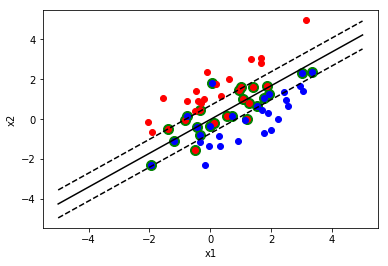

Regular SVM


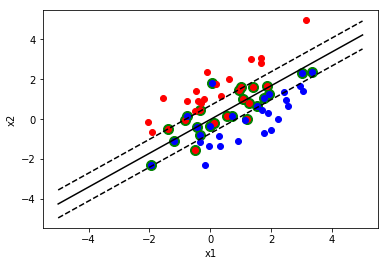

SVMDelta+ The simplified approach


(None, None, None, None)

In [24]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svm_clf), print("Regular SVM"), plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdpsa_clf), print("SVMDelta+ The simplified approach")

Wait... after all that, they're the same?!?! What gives? Yeah... I'd have loved it if if was more impressive. But the only additional term is $\sum_{i=1}^{\ell}\alpha_i\xi_i^*\leq C\sum_{i=1}^{\ell}\xi_i^*$ and if your $\xi^*$, the margin violation in the privileged space, is 0. Well, it's not gonna make any difference. Let alone the fact that most $\alpha$'s are 0. We're looking for support vectors (non-zero $\alpha$'s) in $X$ space, that the data for them in the corresponding priviliged space $X^*$ is in breach of the margin. And given this toy data, that's not happening.

## SVM$_\Delta$+ - The not so simple approach

Well, the simplified approach wax a bit of a let down on the toy data. We might come back to it with some real data and see if it improves, but until then, let's look at the more complicated version and see if it manages to do any better. Here it is...

$$\begin{equation}
\begin{aligned}
\min_{\textbf{w},b,\textbf{w}^*,b^*} \quad \frac{1}{2}(||\textbf{w}||^2 + \gamma ||\textbf{w}^*||^2) & + C\sum_{i=1}^{\ell} [y_i((\textbf{w}^* \cdot \textbf{x}^*_i) + b^*) + \zeta_i] + \Delta C \sum_{i=1}^{\ell}\zeta_i \\
\textrm{subject to} & \quad y_i(\textbf{w} \cdot \textbf{x}_i+b)\geq 1 - y_i((\textbf{w}^* \cdot \textbf{x}^*_i) + b^*)-\zeta_i \\
\textrm{and} & \quad y_i((\textbf{w}^* \cdot \textbf{x}^*_i) + b^*) + \zeta_i \geq 0 \\
\textrm{and} & \quad \zeta_i \geq 0 
\end{aligned}
\end{equation}$$

Crumbs, that looks complicated. But it's similar in form to the SVM. We have a term that we want to minimise subject to a few things. Let's do what we did with the SVM and get the dual form and see if we can follow the steps we did before.

$$\begin{equation}
\begin{aligned}
\max_{\alpha, (C-\beta)} \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{\ell}\alpha_i \alpha_j y_i y_j (\textbf{x}_i \cdot \textbf{x}_j) - & \frac{1}{2\gamma}\sum_{i, j = 1}^{\ell}y_i y_j(C-\beta_i - \alpha_i)(C-\beta_j - \alpha_j)(\textbf{x}_i^* \cdot \textbf{x}_j^*) \\
\textrm{subject to} & \quad \sum_{i=1}^{\ell} y_i \alpha_i = 0 \\
\textrm{and} & \quad \sum_{i=1}^{\ell} y_i C-\beta_i = 0 \\
\textrm{and} & \quad 0 \leq C-\beta_i \leq C \\
\textrm{and} & \quad 0 \leq \alpha_i \leq C-\beta_i +\Delta C
\end{aligned}
\end{equation}$$

Let's neaten it up a bit and say $C-\beta = \delta$

$$\begin{equation}
\begin{aligned}
\max_{\alpha, \delta} \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{\ell}\alpha_i \alpha_j y_i y_j (\textbf{x}_i \cdot \textbf{x}_j) - & \frac{1}{2\gamma}\sum_{i, j = 1}^{\ell}y_i y_j(\delta_i - \alpha_i)(\delta_j - \alpha_j)(\textbf{x}_i^* \cdot \textbf{x}_j^*) \\
\textrm{subject to} & \quad \sum_{i=1}^{\ell} y_i \alpha_i = 0 \\
\textrm{and} & \quad \sum_{i=1}^{\ell} y_i \delta_i = 0 \\
\textrm{and} & \quad 0 \leq \delta_i \leq C \\
\textrm{and} & \quad 0 \leq \alpha_i \leq \delta_i +\Delta C
\end{aligned}
\end{equation}$$

So looking at the constraints, goven that we've done this kind of thing before, they shouldn't be too much of a problem. Yes, there's now an extra variable, $\delta$, but we can deal with that. The more scary looking one is the top line. Unfotunately I'm not an expert in just wizardly turning that into one matrix. However, [this paper](http://www.cse.psu.edu/~zbc102/files/svm_plus_technical_report_15.pdf) solves a problem that looks very similar.
$$\begin{equation}
\begin{aligned}
\max_{\alpha, \delta} \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{\ell}\alpha_i \alpha_j y_i y_j (\textbf{x}_i \cdot \textbf{x}_j) - & \frac{\gamma}{2}\sum_{i, j = 1}^{\ell}y_i y_j(\alpha_i- \delta_i)(\alpha_j - \delta_j)(\textbf{x}_i^* \cdot \textbf{x}_j^*) \\
\textrm{subject to} & \quad \sum_{i=1}^{\ell} y_i \alpha_i = 0 \\
\textrm{and} & \quad \sum_{i=1}^{\ell} y_i \delta_i = 0 \\
\textrm{and} & \quad 0 \leq \delta_i \leq C_i \\
\textrm{and} & \quad 0 \leq \alpha_i \leq \kappa C_i
\end{aligned}
\end{equation}$$

Let's look at the differences 
1. The placing of $\gamma$, well that's no biggie, it will still have the same effect. 
2. We talk about $(\alpha_i - \delta_i)$, the other paper solves $(\delta_i - \alpha_i)$. Now this could be a bit of a problem, we'll talk about it in a bit.
3. They talk about $\kappa C$, we're looking at $\delta_i + \Delta C$. That's easy enough, we can just change a contstraint a little bit.
4. They talk about $C_i$. This is a bit confusing as $C$ is a constant. I'm hoping this is a typo and nothing more profound.

Let's get the constraints out of the way, because we can do them easily. First off, the inequalities.

G1 and h1 $-\delta_i \leq 0$

G2 and h2 $\delta_i \leq C$

G3 and h3 $-\alpha_i \leq 0$

G4 and h4 $\alpha_i \leq \delta_i + \Delta C$ which we'll jig about to be $\alpha_i - \delta_i \leq  \Delta C$

The thing to remember is that these are being multiplied by two variables, as such we need to remember that we will be multiplying $G$ by $\begin{equation}
\begin{pmatrix} \alpha \\
\delta
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G1 = 
\begin{pmatrix} 0 & 0 & \cdots & 0_{1,n} & -1_{1,n+1} & 0 & \cdots & 0_{1,2n} \\
0 & 0 & \cdots & 0_{2,n} & 0_{2,n+1} & -1 & \cdots & 0_{2,2n} \\
\vdots & \cdots & \ddots & \vdots & \vdots & \cdots & \ddots & \vdots \\
0_{n,1} & \cdots & 0 & 0_{n,n} & 0_{n, n+1} & \cdots & 0 & -1_{n,2n}
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h1 = 
\begin{pmatrix} 0_1 \\
0_2 \\
\vdots \\
0_n
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G2 = 
\begin{pmatrix} 0 & 0 & \cdots & 0_{1,n} & 1_{1,n+1} & 0 & \cdots & 0_{1,2n} \\
0 & 0 & \cdots & 0_{2,n} & 0_{2,n+1} & 1 & \cdots & 0_{2,2n} \\
\vdots & \cdots & \ddots & \vdots & \vdots & \cdots & \ddots & \vdots \\
0_{n,1} & \cdots & 0 & 0_{n,n} & 0_{n, n+1} & \cdots & 0 & 1_{n,2n}
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h2 = 
\begin{pmatrix} C_1 \\
C_2 \\
\vdots \\
C_n
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G3 = 
\begin{pmatrix} -1_{1,1} & 0 & \cdots & 0_{1,n} & 0_{1,n+1} & 0 & \cdots & 0_{1,2n} \\
0_{2,1} & -1 & \cdots & 0_{2,n} & 0_{2,n+1} & 0 & \cdots & 0_{2,2n} \\
\vdots & \cdots & \ddots & \vdots & \vdots & \cdots & \ddots & \vdots \\
0_{n, 1} & \cdots & 0 & -1_{n,n} & 0_{n,n+1} & \cdots & 0 & 0_{n,2n}
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h3 = 
\begin{pmatrix} 0_1 \\
0_2 \\
\vdots \\
0_n
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G4 = 
\begin{pmatrix} 1_{1,1} & 0 & \cdots & 0_{1,n} & -1_{1,n+1} & 0 & \cdots & 0_{1,2n} \\
0_{2,1} & 1 & \cdots & 0_{2,n} & 0_{2,n+1} & -1 & \cdots & 0_{2,2n} \\
\vdots & \cdots & \ddots & \vdots & \vdots & \cdots & \ddots & \vdots \\
0_{n, 1} & \cdots & 0 & 1_{n,n} & 0_{n,n+1} & \cdots & 0 & -1_{n,2n}
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h4 = 
\begin{pmatrix} \Delta C \\
\Delta C \\
\vdots \\
\Delta C
\end{pmatrix} 
\end{equation}$

And as before $\begin{equation}
G = 
\begin{pmatrix} G1 \\
G2 \\
G3 \\
G4
\end{pmatrix} 
\end{equation}$
and $\begin{equation}
h = 
\begin{pmatrix} h1 \\
h2 \\
h3 \\
h4
\end{pmatrix} 
\end{equation}$

Now, the equalities!

A1 = $\sum_{i=1}^{\ell}y_i\alpha_i$ b1 = $0$
A2 = $\sum_{i=1}^{\ell}y_i\delta_i$ b2 = 0

$\begin{equation}
A1 = 
\begin{pmatrix} y_1 & y_2 & \cdots & y_n & 0_{n+1} & 0_{n+2} & \cdots & 0_{2n}
\end{pmatrix} 
\end{equation}$ $\begin{equation}
b1 = 
\begin{pmatrix} 0
\end{pmatrix} 
\end{equation}$

$\begin{equation}
A2 = 
\begin{pmatrix} 0_{1} & 0_{2} & \cdots & 0_{n} & y_{n+1} & y_{n+2} & \cdots & y_{2n}
\end{pmatrix} 
\end{equation}$ $\begin{equation}
b2 = 
\begin{pmatrix} 0
\end{pmatrix} 
\end{equation}$

Then stack as with inequalities. 
$\begin{equation}
A = 
\begin{pmatrix} A1 \\
A2 
\end{pmatrix} 
\end{equation}$
and $\begin{equation}
b = 
\begin{pmatrix} b1 \\
b2 
\end{pmatrix} 
\end{equation}$

Yeah, you could've probably done them yourself. But then I wouldn't get to put off this part. In the paper that solves a similar problem, they call their $P$ and $q$, $H$ and $f$. Fine. The $f$ is easy, we're doing a sum over all the negative $\alpha$'s, so $\begin{equation}
f = q = 
\begin{pmatrix} -1_1 & -1_2 & \cdots & -1_n & 0_{n+1} & \cdots & 0_{2n}
\end{pmatrix} 
\end{equation}$

The paper gives $\begin{equation}
H = 
\begin{pmatrix} (\textbf{x}_i,\textbf{x}_j)y_iy_j + \gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j & -\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j \\
-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j & +\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j
\end{pmatrix} 
\end{equation}$

When I've got a bit more time I'll do a proper expansion of H, just know that it's a 2n by 2n matrix. The bit that's confusing me is that we need to go from the optimisation problem to H. Maybe we can work it backwards?

$\begin{equation}
\begin{pmatrix} \alpha & \delta \end{pmatrix} \times
\begin{pmatrix} (\textbf{x}_i,\textbf{x}_j)y_iy_j + \gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j & -\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j \\
-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j & +\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j
\end{pmatrix} \times 
\begin{pmatrix} \alpha \\
\delta
\end{pmatrix}
\end{equation}$

$\begin{pmatrix} (\alpha((\textbf{x}_i,\textbf{x}_j)y_iy_j + \gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j))+(\delta(-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j)) &
(\alpha(-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j))+ 
(\delta(\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j))
\end{pmatrix} \times 
\begin{pmatrix} \alpha \\
\delta
\end{pmatrix}$

$\begin{pmatrix}
\alpha(\alpha((\textbf{x}_i,\textbf{x}_j)y_iy_j + \gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j) +
(\delta(-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j))) & + &
\delta(\alpha(-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j)+ 
(\delta(\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j)))
\end{pmatrix}$

$\begin{pmatrix}
\alpha\alpha((\textbf{x}_i,\textbf{x}_j)y_iy_j + \gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j) +
\alpha\delta(-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j) & + &
\delta\alpha(-\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j)+ 
\delta\delta(\gamma(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j)
\end{pmatrix}$

$\begin{pmatrix}
\alpha\alpha(\textbf{x}_i,\textbf{x}_j)y_iy_j + \gamma\alpha\alpha(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j
-\gamma\alpha\delta(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j
-\gamma\delta\alpha(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j+ 
\gamma\delta\delta(\textbf{x}^*_i,\textbf{x}^*_j)y_iy_j
\end{pmatrix}$

$\begin{pmatrix}
\alpha\alpha y_iy_j(\textbf{x}_i,\textbf{x}_j) + \gamma y_iy_j(\textbf{x}^*_i,\textbf{x}^*_j)\alpha\alpha
-\gamma y_iy_j(\textbf{x}^*_i,\textbf{x}^*_j)\alpha\delta
-\gamma y_iy_j(\textbf{x}^*_i,\textbf{x}^*_j)\alpha\delta+ 
\gamma y_iy_j(\textbf{x}^*_i,\textbf{x}^*_j)\delta\delta
\end{pmatrix}$

$\begin{pmatrix}
\alpha\alpha y_iy_j(\textbf{x}_i,\textbf{x}_j) + \gamma y_iy_j(\textbf{x}^*_i,\textbf{x}^*_j)
(\alpha\alpha-\alpha\delta-\alpha\delta+\delta\delta)
\end{pmatrix}$

I hope you've followed those steps. I'll try to come back and annotate them a bit more, but now we've got to an interesting part. $(\alpha\alpha - \alpha\delta - \alpha\delta + \delta\delta)$. If we factorise this, we get... $(\alpha-\delta)(\alpha-\delta)$. Which is great. But we can also get $(\delta-\alpha)(\delta-\alpha)$. Which is really sweet. The same $H$ or $P$ matrix works for both the problems. Awesome! So let's populate this thing.

In [25]:
kernel = prob.kernel
C = prob.C

L = prob.num
M = prob.dimensions

x = prob.X
y = prob.Y

gamma = prob.gamma
delta = prob.delta

H11 = (prob.xi_xj * prob.yi_yj) + gamma*(prob.xstari_xstarj * prob.yi_yj)
H12 = -gamma*(prob.xstari_xstarj * prob.yi_yj)
H22 = gamma*(prob.xstari_xstarj * prob.yi_yj)
H1 = np.hstack((H11, H12))
H2 = np.hstack((H12, H22))
H = np.vstack((H1, H2))

f = np.hstack((np.repeat(-1, L),np.zeros(L)))

positiveEye = np.eye(L, dtype='d')
negativeEye = -np.eye(L, dtype='d')
zeros = np.zeros((L, L))
g1 = np.hstack((zeros, negativeEye))
g2 = np.hstack((zeros, positiveEye))
g3 = np.hstack((negativeEye, zeros))
g4 = np.hstack((positiveEye, negativeEye))

G = np.vstack((g1,g2))
G = np.vstack((G,g3))
G = np.vstack((G,g4))

h1 = np.zeros(((L),1))
h2 = np.repeat(C, (L)).reshape(-1,1)
h2 = np.vstack((h1, h2))
h3 = np.vstack((h2, h1))
h4 = np.repeat((delta*C), L).reshape(-1,1)
h = np.vstack((h3, h4))

Aeq1 = np.hstack((prob.Y, np.zeros(L)))
Aeq2 = np.hstack((np.zeros(L), prob.Y))
Aeq = np.vstack((Aeq1, Aeq2))

beq = np.zeros(2)
beq = beq.reshape(-1,1)

P = matrix(H, tc='d')
q = matrix(f, tc='d')
G = matrix(G, tc='d')
h = matrix(h, tc='d')
A = matrix(Aeq, tc='d')
b = matrix(beq, tc='d')

solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphasAndDeltas = np.array(sol['x'])
alphas = alphasAndDeltas[:L]
deltas = alphasAndDeltas[L:]

And then we get $\textbf{w}$ in the same way we always have done

In [26]:
w = np.sum(alphas * y[:, None] * x, axis = 0)

The bias however, is slightly different. Instead of $b = \frac{\sum_{s=1}^{S}(y_s-\sum_{m=1}^{S}\alpha_my_m(\textbf{x}_m\cdot\textbf{x}_s))}{\textrm{Number of S}}$ we have $b=1-y_k[\sum_{i=1}^{\ell}\alpha_i(\textbf{x}_i,\textbf{x}_k)]$ where $x_i\neq 0$, $\delta_k \neq C$ and $\alpha_k \neq 0$.

In [27]:
bacond = (alphas > 1e-5)
bdcond = (deltas < C)
bxcond = (x != 0)

bxcond2 = list(range(0, L))
index = 0
for dataPoint in bxcond:
    if np.any(dataPoint):
        bxcond2[index] = True
    else:
        bxcond2[index] = False
    index += 1

bcond = np.array([a and b for a, b in zip(bacond, bdcond)]).flatten()
bcond = np.array([a and b for a, b in zip(bcond, bxcond2)]).flatten()
yK = y[bcond]
xK = x[bcond]

b = []
for k in range(len(xK)):
    b.append(1-yK[k]*np.dot(w, xK[k]))

Ok, so I'm not entirely happy. The there are multiple posints where the $x_i\neq 0$, $\delta_k \neq C$ and $\alpha_k \neq 0$ contraints are valid. So, I'm going to just take the average (mean) point.

In [28]:
bias = (1- (sum(b) / len(b)))

In [29]:
svmdp_clf = classifier() 
svmdp_clf.w = w
svmdp_clf.b = bias
svmdp_clf.alphas = alphas
svmdp_clf.support_vectors = prob.X[bacond.flatten()]

Then let's put all that in a class and see what it looks like shall we?

In [30]:
class SVMdp():
    def train(self, prob : svm_problem):
        self.prob = prob
        self.kernel = self.prob.kernel
        self.C = self.prob.C

        self.L = self.prob.num
        self.M = self.prob.dimensions

        self.x = self.prob.X
        self.y = self.prob.Y

        self.gamma = self.prob.gamma
        self.delta = self.prob.delta

        H11 = (self.prob.xi_xj * self.prob.yi_yj) + self.gamma*(self.prob.xstari_xstarj * self.prob.yi_yj)
        H12 = -self.gamma*(self.prob.xstari_xstarj * self.prob.yi_yj)
        H22 = self.gamma*(self.prob.xstari_xstarj * self.prob.yi_yj)
        H1 = np.hstack((H11, H12))
        H2 = np.hstack((H12, H22))
        H = np.vstack((H1, H2))

        f = np.hstack((np.repeat(-1, self.L),np.zeros(self.L)))

        positiveEye = np.eye(self.L, dtype='d')
        negativeEye = -np.eye(self.L, dtype='d')
        zeros = np.zeros((self.L, self.L))
        g1 = np.hstack((zeros, negativeEye))
        g2 = np.hstack((zeros, positiveEye))
        g3 = np.hstack((negativeEye, zeros))
        g4 = np.hstack((positiveEye, negativeEye))

        G = np.vstack((g1,g2))
        G = np.vstack((G,g3))
        G = np.vstack((G,g4))

        h1 = np.zeros(((self.L),1))
        h2 = np.repeat(self.C, (self.L)).reshape(-1,1)
        h2 = np.vstack((h1, h2))
        h3 = np.vstack((h2, h1))
        h4 = np.repeat((self.delta*self.C), self.L).reshape(-1,1)
        h = np.vstack((h3, h4))

        Aeq1 = np.hstack((self.y, np.zeros(self.L)))
        Aeq2 = np.hstack((np.zeros(self.L), self.y))
        Aeq = np.vstack((Aeq1, Aeq2))

        beq = np.zeros(2)
        beq = beq.reshape(-1,1)

        P = matrix(H, tc='d')
        q = matrix(f, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(Aeq, tc='d')
        b = matrix(beq, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:self.L]
        self.deltas = alphasAndDeltas[self.L:]
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bacond = (self.alphas > 1e-5)
        bdcond = (self.deltas < self.C)
        bxcond = (self.x != 0)

        bxcond2 = list(range(0, self.L))
        index = 0
        for dataPoint in bxcond:
            if np.any(dataPoint):
                bxcond2[index] = True
            else:
                bxcond2[index] = False
            index += 1

        bcond = np.array([a and b for a, b in zip(bacond, bdcond)]).flatten()
        bcond = np.array([a and b for a, b in zip(bcond, bxcond2)]).flatten()
        yK = self.y[bcond]
        xK = self.x[bcond]

        b = []
        for k in range(len(xK)):
            b.append(1-yK[k]*np.dot(w, xK[k]))
        bias = (1- (sum(b) / len(b)))
        
        clf = classifier()
        clf.w = w
        clf.b = bias
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond.flatten()]
        return clf

In [31]:
svmdp = SVMdp()
svmdp_clf = svmdp.train(prob)

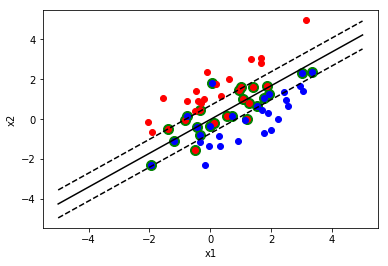

Regular SVM


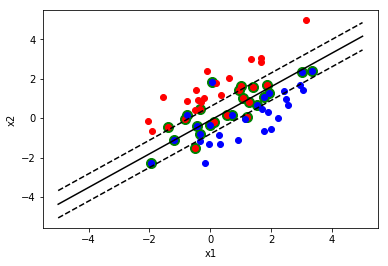

The SVMdp trained with privileged information


(None, None, None, None)

In [32]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svm_clf), print("Regular SVM"), plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdp_clf), print("The SVMdp trained with privileged information")

Whoah!!!! What's happened? Well, you should see that the angle of the decision boundary (the weights) is slightly different. Why's that? Good question. I'll have a think about it and try to report back.

Also, every time I run this the decision boundary seems to move in favour of class +1 (shifting down). I'm not sure why that is. Another thing to ponder... Maybe my bias isn't right... I did decide to make it an average....

Until $b$ is sorted, let's get on with something else.. Just for fun, let's try and implement the regular SVM+ described in equations 1.6 - 1.8 of [this book](http://www.cs.technion.ac.il/~pechyony/book_chapter.pdf)

## SVM+

For completeness... The primal problem is 

$$
\begin{aligned}
\min_{w, w^*, b, b^*} \quad & \frac{1}{2}[(w,w)+\gamma(w^*,w^*)]+C\sum_{i=1}^{\ell}[(w^*,x^*_i)+b^*] \\
\textrm{subject to} \quad & y_i[(w,x_i)+b] \geq 1- [(w^*,x^*)+b^*] \\
\textrm{and} \quad & [(w^*,x_i^*)+b^*] \geq 0
\end{aligned}
$$

Which gives us the dual to solve 

$$
\begin{aligned}
\max_{\alpha, \beta} \quad & \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{\ell}\alpha_i\alpha_jy_iy_j(x_i,x_j) -\frac{1}{2\gamma}\sum_{i,j=1}^{\ell}(\alpha_i+\beta_i-C)(\alpha_j+\beta_j-C)(x^*_i, x^*_j) \\
\textrm{subject to} \quad & \sum_{i=1}^{\ell}(\alpha_i+\beta_i-C) = 0 \\
\textrm{and} \quad & \sum_{i=1}^{\ell}y_i\alpha_i = 0 \\
\textrm{and} \quad & \alpha_i \geq 0 \\
\textrm{and} \quad & \beta_i \geq 0
\end{aligned}
$$

Now, similarly to with the SVM$_\Delta$+, lets say $\beta - C = \delta$

$$
\begin{aligned}
\max_{\alpha, \beta} \quad & \sum_{i=1}^{\ell}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{\ell}\alpha_i\alpha_jy_iy_j(x_i,x_j) -\frac{1}{2\gamma}\sum_{i,j=1}^{\ell}(\alpha_i+\delta_i)(\alpha_j+\delta_j)(x^*_i, x^*_j) \\
\textrm{subject to} \quad & \sum_{i=1}^{\ell}(\alpha_i+\delta_i) = 0 \\
\textrm{and} \quad & \sum_{i=1}^{\ell}y_i\alpha_i = 0 \\
\textrm{and} \quad & \alpha_i \geq 0 \\
\textrm{and} \quad & \delta_i \geq -C
\end{aligned}
$$

Let's see if we can work the main problem back using the SVM$_\Delta$+ as a guide

$\begin{pmatrix}
\alpha\alpha y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j)(\alpha\alpha+\alpha\delta+\alpha\delta+\delta\delta)
\end{pmatrix}$

$\begin{pmatrix}
\alpha\alpha y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j)\alpha\alpha+\gamma(x^*_i,x^*_j)\alpha\delta & + & \gamma(x^*_i,x^*_j)\alpha\delta+\gamma(x^*_i,x^*_j)\delta\delta)
\end{pmatrix}$

$\begin{pmatrix}
\alpha(\alpha y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j)\alpha+\gamma(x^*_i,x^*_j)\delta) & + & \delta(\gamma(x^*_i,x^*_j)\alpha+\gamma(x^*_i,x^*_j)\delta))
\end{pmatrix}$

$\begin{pmatrix}
\alpha y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j)\alpha+\gamma(x^*_i,x^*_j)\delta & + & \gamma(x^*_i,x^*_j)\alpha+\gamma(x^*_i,x^*_j)\delta)
\end{pmatrix}
\times
\begin{pmatrix}
\alpha \\
\delta
\end{pmatrix}
$

$\begin{pmatrix}
\alpha (y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j))+\delta(\gamma(x^*_i,x^*_j)) & + & \alpha(\gamma(x^*_i,x^*_j))+\delta(\gamma(x^*_i,x^*_j))
\end{pmatrix}
\times
\begin{pmatrix}
\alpha \\
\delta
\end{pmatrix}
$

$\begin{pmatrix}
\alpha & \delta
\end{pmatrix}
\times
\begin{pmatrix}
(y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j)) & + & (\gamma(x^*_i,x^*_j))\\ 
(\gamma(x^*_i,x^*_j)) & + & (\gamma(x^*_i,x^*_j))
\end{pmatrix}
\times
\begin{pmatrix}
\alpha \\
\delta
\end{pmatrix}
$

In terms of CVXOPT this gives us $P =$
$
\begin{pmatrix}
(y_iy_j(x_i,x_j) + \gamma(x^*_i,x^*_j)) & (\gamma(x^*_i,x^*_j))\\ 
(\gamma(x^*_i,x^*_j)) & (\gamma(x^*_i,x^*_j))
\end{pmatrix}
$

and $q = 
\begin{pmatrix}
-1_1 & -1_2 & \cdots & -1_n & 0_{n+1} & \cdots & 0_{2n}
\end{pmatrix}
$

The inequalities:-

G1 and h1 = $-\alpha_i \leq 0$ 

G2 and h2 = $-\delta_i \leq C$

$\begin{equation}
G1 = 
\begin{pmatrix} -1_{1,1} & 0 & \cdots & 0_{1,n} & 0_{1,n+1} & 0_{1,2n-1} & \cdots & 0_{1,2n} \\
0_{2,1} & -1_{2,2} & \cdots & 0_{2,n} & 0_{2,n+1} & 0_{2,n+2} & \cdots & 0_{2,2n} \\
\vdots & \cdots & \ddots & \vdots & \vdots & \cdots & \ddots & \vdots \\
0_{n,1} & \cdots & 0_{n,n-1} & -1_{n,n} & 0_{n, n+1} & \cdots & 0 & 0_{n,2n}
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h1 = 
\begin{pmatrix} 0_1 \\
0_2 \\
\vdots \\
0_n
\end{pmatrix} 
\end{equation}$

$\begin{equation}
G2 = 
\begin{pmatrix} 0_{1,1} & 0_{1,2} & \cdots & 0_{1,n} & -1_{1,n+1} & 0_{1,n+2} & \cdots & 0_{1,2n} \\
0_{2,1} & 0_{2,2} & \cdots & 0_{2,n} & 0_{2,n+1} & -1_{2,n+2} & \cdots & 0_{2,2n} \\
\vdots & \cdots & \ddots & \vdots & \vdots & \cdots & \ddots & \vdots \\
0_{n,1} & \cdots & 0_{n,2} & 0_{n,n} & 0_{n, n+1} & \cdots & 0_{n,2n-1} & -1_{n,2n}
\end{pmatrix} 
\end{equation}$
$\begin{equation}
h2 = 
\begin{pmatrix} C_1 \\
C_2 \\
\vdots \\
C_n
\end{pmatrix} 
\end{equation}$

and as always $G=\begin{pmatrix}G1\\G2\end{pmatrix}$ and $h=\begin{pmatrix}h1\\h2\end{pmatrix}$

For the equalities:-

A1 and b1 = $\sum_{i=1}^{\ell}\alpha_i + \delta_i = 0$

A2 and b2 = $\sum_{i=1}^{\ell}y_i\alpha_i = 0$

$A1 = \begin{pmatrix}
1_1 & 1_2 & \cdots & 1_n & 1_{n+1} & \cdots & 1_{2n}
\end{pmatrix}$ $b1 = \begin{pmatrix}0\end{pmatrix}$

$A2 = \begin{pmatrix}
y_1 & y_2 & \cdots & y_n & 0_{n+1} & \cdots & 0_{2n}
\end{pmatrix}$ $b2 = \begin{pmatrix}0\end{pmatrix}$

Then again, rather unceremoniously $A = \begin{pmatrix}A1 \\ A2\end{pmatrix}$ and $b = \begin{pmatrix}b1 \\ b2\end{pmatrix}$

In [33]:
C = prob.C

L = prob.num

y = prob.Y

gamma = prob.gamma

P1 = (prob.xi_xj * prob.yi_yj) + gamma*(prob.xstari_xstarj)
P2 = gamma*(prob.xstari_xstarj)
P11 = np.hstack((P1, P2))
P22 = np.hstack((P2, P2))
P = np.vstack((P11, P22))

q = np.hstack((np.repeat(-1, L),np.zeros(L)))

negativeEye = -np.eye(L, dtype='d')
zeros = np.zeros((L, L))
g1 = np.hstack((negativeEye, zeros))
g2 = np.hstack((zeros, negativeEye))

G = np.vstack((g1,g2))

h1 = np.zeros(((L),1))
h2 = np.repeat(C, (L)).reshape(-1,1)
h = np.vstack((h1, h2))

A1 = np.repeat(1, 2*L)
A2 = np.hstack((y, np.zeros(L)))
A = np.vstack((A1, A2))

b = np.zeros(2)
b = beq.reshape(-1,1)

P = matrix(P, tc='d')
q = matrix(q, tc='d')
G = matrix(G, tc='d')
h = matrix(h, tc='d')
A = matrix(A, tc='d')
b = matrix(b, tc='d')

solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphasAndDeltas = np.array(sol['x'])
alphas = alphasAndDeltas[:L]
deltas = alphasAndDeltas[L:]

# Not really writing about it, w as before
w = np.sum(alphas * y[:, None] * x, axis = 0)

The bias $b$ is a bit more interesting. To work it out we need 

$F_i = \sum_{j=1}^{n} \alpha_j y_j (x_i,x_j)$


$f_i = \sum_{j=1}^{n} (\alpha_j + \delta_j) (x^*_i,x^*_j)$


$s_+ = \sum_{i:\alpha_i>0, y=1}^{\ell}1-\frac{f_i}{\gamma}-F_i$


$s_- = \sum_{i:\alpha_i>0, y=-1}^{\ell}1-\frac{f_i}{\gamma}-F_i$


$n_+ = |\{i : \alpha_i > 0, y_i = 1\}|$


$n_- = |\{i : \alpha_i > 0, y_i = -1\}|$


And this is all to tell us that $$b = \frac{\frac{s_+}{n_+} + \frac{s_-}{n_-}}{2}$$

In [34]:
def F(i):
    runningTotal = 0
    for j in range(L):
        runningTotal += alphas[j] * prob.Y[j] * prob.kernel(prob.X[i], prob.X[j])
    return runningTotal[0]

In [35]:
def f(i):
    runningTotal = 0
    for j in range(L):
        runningTotal += (alphas[j] + deltas[j]) * prob.kernel(prob.Xstar[i], prob.Xstar[j])
    return runningTotal[0]

In [36]:
def sPos():
    runningTotal = 0
    for i in range(L):
        if alphas[i] > 1e-5 and prob.Y[i] == 1:
            runningTotal += 1-(f(i)/gamma)-F(i)
    return runningTotal

In [37]:
def sNeg():
    runningTotal = 0
    for i in range(L):
        if alphas[i] > 1e-5 and prob.Y[i] == -1:
            runningTotal += 1-(f(i)/gamma)-F(i)
    return runningTotal

In [38]:
def nPos():
    runningTotal = 0
    for i in range(L):
        if alphas[i] > 1e-5 and prob.Y[i] == 1:
            runningTotal += 1
    return runningTotal

In [39]:
def nNeg():
    runningTotal = 0
    for i in range(L):
        if alphas[i] > 1e-5 and prob.Y[i] == -1:
            runningTotal += 1
    return runningTotal

In [40]:
def getB():
    return ((sPos()/nPos())+(sNeg()/nNeg()))/2

In [41]:
getB()

1.0000000017290052

Let's put all that together and see it in action shall we?

In [42]:
class SVMp():
    def train(self, prob : svm_problem):
        self.prob = prob
        self.C = self.prob.C

        self.L = self.prob.num

        self.x = self.prob.X
        self.xStar = self.prob.Xstar
        self.y = self.prob.Y

        self.gamma = self.prob.gamma

        P1 = (self.prob.xi_xj * self.prob.yi_yj) + self.gamma*(self.prob.xstari_xstarj)
        P2 = self.gamma*(self.prob.xstari_xstarj)
        P11 = np.hstack((P1, P2))
        P22 = np.hstack((P2, P2))
        P = np.vstack((P11, P22))

        q = np.hstack((np.repeat(-1, self.L),np.zeros(self.L)))

        negativeEye = -np.eye(self.L, dtype='d')
        zeros = np.zeros((self.L, self.L))
        g1 = np.hstack((negativeEye, zeros))
        g2 = np.hstack((zeros, negativeEye))

        G = np.vstack((g1,g2))

        h1 = np.zeros(((self.L),1))
        h2 = np.repeat(self.C, (self.L)).reshape(-1,1)
        h = np.vstack((h1, h2))

        A1 = np.repeat(1, 2*self.L)
        A2 = np.hstack((self.y, np.zeros(self.L)))
        A = np.vstack((A1, A2))

        b = np.zeros(2)
        b = b.reshape(-1,1)

        P = matrix(P, tc='d')
        q = matrix(q, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(A, tc='d')
        b = matrix(b, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:self.L]
        self.deltas = alphasAndDeltas[self.L:]

        # Not really writing about it, w as before        
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bias = self.getB()
        
        clf = classifier()
        clf.w = w
        clf.b = bias
        clf.alphas = self.alphas
        clf.support_vectors = self.x[(self.alphas > 1e-5).flatten()]
        return clf
    
    def F(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += self.alphas[j] * self.y[j] * self.prob.kernel(self.x[i], self.x[j])
        return runningTotal[0]
    
    def f(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += (self.alphas[j] + self.deltas[j]) * self.prob.kernel(self.xStar[i], self.xStar[j])
        return runningTotal[0]
    
    def sPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def sNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def nPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1
        return runningTotal
    
    def nNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1
        return runningTotal
    
    def getB(self):
        return ((self.sPos()/self.nPos())+(self.sNeg()/self.nNeg()))/2

In [43]:
svmp = SVMp()
svmp_clf = svmp.train(prob)

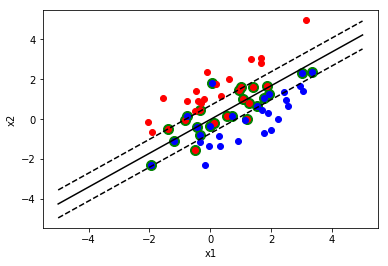

Regular SVM


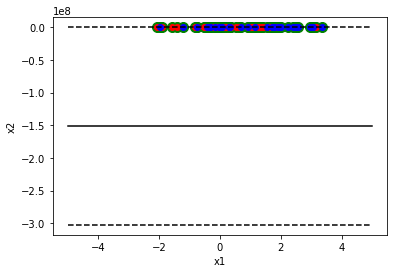

The SVM+ trained with privileged information


(None, None, None, None)

In [44]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svm_clf), print("Regular SVM"), plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmp_clf), print("The SVM+ trained with privileged information")

***!!!! WHAT?!?!?!?!?!?!??!?*** This isn't good. So let's try and tease apart why this isn't working. 

What's being plotted is simply $y = wx + b$.

So firstly let's check the value of $b$ to make sure it's nothing crazy.

In [45]:
print("bias in SVM = ", svmp_clf.b)
print("bias in SVMd+simp = ", svmdpsa_clf.b)
print("bias in SVMd+ = ", svmdp_clf.b)
print("bias in SVM+ = ", svmp_clf.b)

bias in SVM =  1.00000000173
bias in SVMd+simp =  [ 0.01720029]
bias in SVMd+ =  0.157038289351
bias in SVM+ =  1.00000000173


So, no. That's not crazy. In that case the only other option is $w$ having a problem as we don't touch the $x$ value.

$w$ is the summation of the $\alpha$ times $y$ and $x$. Again, we don't touch $y$ or $x$, so the values to look at are the $\alpha$'s. The $\alpha$'s should be 0, except for the ones which coincide with the support vectors. So let's look at them. (To save space they're reshaped from a column-vector to an array - this is only to save a bit of room)

In [46]:
svmp_clf.alphas.flatten()

array([  0.76743266,   0.7289922 ,   0.64271262,   0.62073751,
         0.78199111,   0.30071131,   0.33054392,   0.45691013,
         0.56365184,   0.60491454,   0.42268472,   1.67932562,
         1.37910112,   0.64924484,   1.56783214,   0.73893284,
         0.63400926,   1.0339306 ,   0.87854122,   0.73635149,
         0.87873428,   1.50601475,   0.49267123,   6.28723192,
         0.42791001,   0.53430442,   1.90067567,   0.68324863,
         1.22728646,   0.54336949,   0.32170251,   0.40584831,
         1.06170193,   0.60108716,   0.84295065,   0.75552615,
         0.67423321,   0.68332744,   0.83911097,   0.70047956,
         0.52987476,   0.77841083,   0.38391983,   0.59069543,
         0.41067303,   0.59821938,   0.42797715,   0.52790053,
         0.53933703,   0.57806665,   0.30786832,   0.94557351,
         0.70782327,   0.52129691,   0.54913852,  11.28266882,
         0.66924436,   0.36186544,   1.93090071,   0.47257618])

O M actual G. These values are massive. No wonder problems are arising. The eagle eyed amongst you will have noticed that in every other SVM we've trained the $\alpha$ is constrained to be between $0$ and $C$, but that isn't the case here. It's only constrained to be greater than $0$. 

[This pdf of Vapnik's 2009 paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=0ahUKEwjfqrPj9YLSAhVCJMAKHR3HAXQQFggoMAE&url=http%3A%2F%2Fwww.neuromorphs.net%2Fnm%2Fraw-attachment%2Fwiki%2F2015%2Fmfa15%2FVapnik-2009.pdf&usg=AFQjCNG5r5Kg4N4cs_BWTjNBjGsBJr79WA&sig2=-dN1-LFq6BXvGuemWkCVdw) says "When the first constraint ($\sum_{i=1}^{\ell}(\alpha_i+\beta_i-C)=0$) is valid as $\alpha_i+\beta_i-C = 0, i =1 \cdots \ell$ rather than the overall sum being 0", "the third term in $\max_{\alpha, \beta}\sum_{i=1}^{\ell}\alpha_i - \frac{1}{2}\sum_{i,j=1}^{\ell}\alpha_i\alpha_jy_iy_j(x_i,x_j) -\frac{1}{2\gamma}\sum_{i,j=1}^{\ell}(\alpha_i+\beta_i-C)(\alpha_j+\beta_j-C)(x^*_i, x^*_j)$ reduces to 0 and the constraints $\sum_{i=1}^{\ell}(\alpha_i+\beta_i-C)=0, \sum_{i=1}^{\ell}y_i\alpha_i = 0, \alpha_i \geq 0, \beta_i \geq 0$ become equivalent to constraints $\sum_{i=1}^{\ell}y_i \alpha_i = 0, 0\leq \alpha_i \leq C$.

Now call me old fashioned, but there's no way that $\alpha$ is suddenly constrained to being less than $C$ without us telling it that it is. I'm going to write the SVM+ with the added constraint that $\alpha \leq C$

In [47]:
class SVMpA(): # The A stands for amended.
    def train(self, prob : svm_problem):
        self.prob = prob
        self.C = self.prob.C
        self.L = self.prob.num
        self.x = self.prob.X
        self.xStar = self.prob.Xstar
        self.y = self.prob.Y

        self.gamma = self.prob.gamma

        P1 = (self.prob.xi_xj * self.prob.yi_yj) + self.gamma*(self.prob.xstari_xstarj)
        P2 = self.gamma*(self.prob.xstari_xstarj)
        P11 = np.hstack((P1, P2))
        P22 = np.hstack((P2, P2))
        P = np.vstack((P11, P22))

        q = np.hstack((np.repeat(-1, self.L),np.zeros(self.L)))

        positiveEye = np.eye(self.L, dtype='d')
        negativeEye = -np.eye(self.L, dtype='d')
        zeros = np.zeros((self.L, self.L))
        g1 = np.hstack((negativeEye, zeros))
        g2 = np.hstack((zeros, negativeEye))
        g3 = np.hstack((positiveEye, zeros))

        G = np.vstack((g1,g2))
        G = np.vstack((G, g3))

        h1 = np.zeros(((self.L),1))
        h2 = np.repeat(self.C, (self.L)).reshape(-1,1)
        h = np.vstack((h1, h2))
        h = np.vstack((h, h2))

        A1 = np.repeat(1, 2*self.L)
        A2 = np.hstack((self.y, np.zeros(self.L)))
        A = np.vstack((A1, A2))

        b = np.zeros(2)
        b = b.reshape(-1,1)

        P = matrix(P, tc='d')
        q = matrix(q, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(A, tc='d')
        b = matrix(b, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:self.L]
        self.deltas = alphasAndDeltas[self.L:]

        # Not really writing about it, w as before        
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bias = self.getB()
        
        clf = classifier()
        clf.w = w
        clf.b = bias
        clf.alphas = self.alphas
        clf.support_vectors = self.x[(self.alphas > 1e-5).flatten()]
        return clf
    
    def F(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += self.alphas[j] * self.y[j] * self.prob.kernel(self.x[i], self.x[j])
        return runningTotal[0]
    
    def f(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += (self.alphas[j] + self.deltas[j]) * self.prob.kernel(self.xStar[i], self.xStar[j])
        return runningTotal[0]
    
    def sPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def sNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def nPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1
        return runningTotal
    
    def nNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1
        return runningTotal
    
    def getB(self):
        return ((self.sPos()/self.nPos())+(self.sNeg()/self.nNeg()))/2

Then let's plot it and see what it looks like

In [48]:
svmpA = SVMpA()
svmpA_clf = svmpA.train(prob)

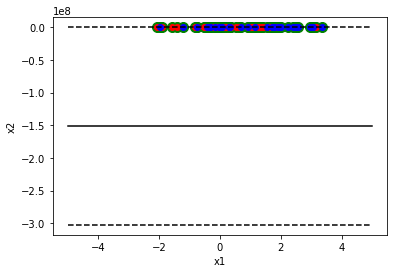

Strict SVM+


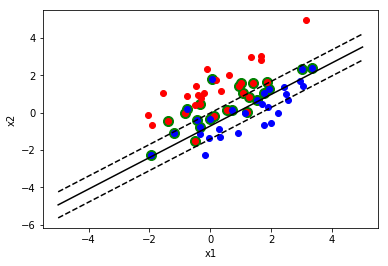

SVM+ amended to have alpha constrained <= C


(None, None, None, None)

In [49]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmp_clf), print("Strict SVM+"), plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmpA_clf), print("SVM+ amended to have alpha constrained <= C")

That looks a lot better, but I need to find out if this is the right approach. I'll come back to it once I've asked about it.

Annoyingly it *looks* as though it again favours the red class... Maybe this is something inherent to privileged information. I need to have a think about this.

But whilst we have the SVM+ method of finding $b$, shall we see if it works

### Out of interest

Shall we try the bias function from the SVM+ in the SVM$_\Delta$+? 

Quick note, in the SVM$_\Delta$+ $\delta = C-\beta$ and in the SVM+ $\delta = \beta - C$. This means the function $f_i$ will need a little change from $f_i = \sum_{j=1}^{n}(\alpha_j + \delta)(x_i,x_j)$ to $f_i = \sum_{j=1}^{n}(\delta_j-\alpha_j)(x_i,x_j)$. The reason for this is not only the difference in the definition of $\delta$, but the different objective functions.

In [50]:
class SVMdpA(): # The A is for amended
    def train(self, prob : svm_problem):
        self.prob = prob
        self.kernel = self.prob.kernel
        self.C = self.prob.C

        self.L = self.prob.num
        self.M = self.prob.dimensions

        self.x = self.prob.X
        self.xStar = self.prob.Xstar
        self.y = self.prob.Y

        self.gamma = self.prob.gamma
        self.delta = self.prob.delta

        H11 = (self.prob.xi_xj * self.prob.yi_yj) + self.gamma*(self.prob.xstari_xstarj * self.prob.yi_yj)
        H12 = -self.gamma*(self.prob.xstari_xstarj * self.prob.yi_yj)
        H22 = self.gamma*(self.prob.xstari_xstarj * self.prob.yi_yj)
        H1 = np.hstack((H11, H12))
        H2 = np.hstack((H12, H22))
        H = np.vstack((H1, H2))

        f = np.hstack((np.repeat(-1, self.L),np.zeros(self.L)))

        positiveEye = np.eye(self.L, dtype='d')
        negativeEye = -np.eye(self.L, dtype='d')
        zeros = np.zeros((self.L, self.L))
        g1 = np.hstack((zeros, negativeEye))
        g2 = np.hstack((zeros, positiveEye))
        g3 = np.hstack((negativeEye, zeros))
        g4 = np.hstack((positiveEye, negativeEye))

        G = np.vstack((g1,g2))
        G = np.vstack((G,g3))
        G = np.vstack((G,g4))

        h1 = np.zeros(((self.L),1))
        h2 = np.repeat(self.C, (self.L)).reshape(-1,1)
        h2 = np.vstack((h1, h2))
        h3 = np.vstack((h2, h1))
        h4 = np.repeat((self.delta*self.C), self.L).reshape(-1,1)
        h = np.vstack((h3, h4))

        Aeq1 = np.hstack((self.y, np.zeros(self.L)))
        Aeq2 = np.hstack((np.zeros(self.L), self.y))
        Aeq = np.vstack((Aeq1, Aeq2))

        beq = np.zeros(2)
        beq = beq.reshape(-1,1)

        P = matrix(H, tc='d')
        q = matrix(f, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(Aeq, tc='d')
        b = matrix(beq, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:self.L]
        self.deltas = alphasAndDeltas[self.L:]
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        bacond = (self.alphas > 1e-5)
        bdcond = (self.deltas < self.C)
        bxcond = (self.x != 0)

        bxcond2 = list(range(0, self.L))
        index = 0
        for dataPoint in bxcond:
            if np.any(dataPoint):
                bxcond2[index] = True
            else:
                bxcond2[index] = False
            index += 1

        bcond = np.array([a and b for a, b in zip(bacond, bdcond)]).flatten()
        bcond = np.array([a and b for a, b in zip(bcond, bxcond2)]).flatten()
        yK = self.y[bcond]
        xK = self.x[bcond]

        #b = []
        #for k in range(len(xK)):
        #    b.append(1-yK[k]*np.dot(w, xK[k]))
        #bias = (1- (sum(b) / len(b)))
        
        clf = classifier()
        clf.w = w
        clf.b = self.getB()
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond.flatten()]
        return clf
    
    def F(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += self.alphas[j] * self.y[j] * self.prob.kernel(self.x[i], self.x[j])
        return runningTotal[0]
    
    def f(self, i):
        runningTotal = 0
        for j in range(self.L):
            runningTotal += (self.deltas[j] - self.alphas[j]) * self.prob.kernel(self.xStar[i], self.xStar[j])
        return runningTotal[0]
    
    def sPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def sNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1-(self.f(i)/self.gamma)-self.F(i)
        return runningTotal
    
    def nPos(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == 1:
                runningTotal += 1
        return runningTotal
    
    def nNeg(self):
        runningTotal = 0
        for i in range(self.L):
            if self.alphas[i] > 1e-5 and self.y[i] == -1:
                runningTotal += 1
        return runningTotal
    
    def getB(self):
        return ((self.sPos()/self.nPos())+(self.sNeg()/self.nNeg()))/2

In [51]:
svmdpA = SVMdpA()
svmdpA_clf = svmdpA.train(prob)

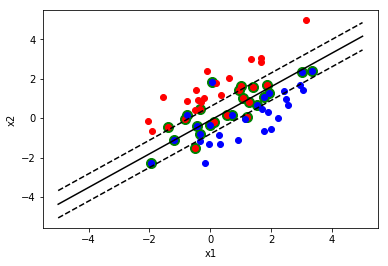

Strict SVMd+


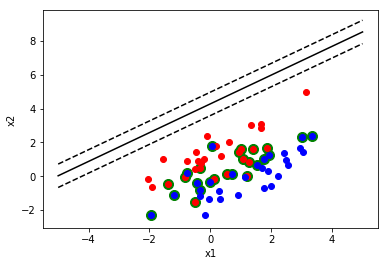

SVMd+ amended to have the bias from SVM+


(None, None, None, None)

In [52]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdp_clf), print("Strict SVMd+"), plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdpA_clf), print("SVMd+ amended to have the bias from SVM+")

HAHAHAHA, this isnt very good! 

Hmm... This is interesting... Let's try the SVM+ with the bias I've got for the SVM$_\Delta$+

In [53]:
class SVMpAA(): # The AA stands for amended amended.
    def train(self, prob : svm_problem):
        self.prob = prob
        self.C = self.prob.C
        self.L = self.prob.num
        self.x = self.prob.X
        self.xStar = self.prob.Xstar
        self.y = self.prob.Y

        self.gamma = self.prob.gamma

        P1 = (self.prob.xi_xj * self.prob.yi_yj) + self.gamma*(self.prob.xstari_xstarj)
        P2 = self.gamma*(self.prob.xstari_xstarj)
        P11 = np.hstack((P1, P2))
        P22 = np.hstack((P2, P2))
        P = np.vstack((P11, P22))

        q = np.hstack((np.repeat(-1, self.L),np.zeros(self.L)))

        positiveEye = np.eye(self.L, dtype='d')
        negativeEye = -np.eye(self.L, dtype='d')
        zeros = np.zeros((self.L, self.L))
        g1 = np.hstack((negativeEye, zeros))
        g2 = np.hstack((zeros, negativeEye))
        g3 = np.hstack((positiveEye, zeros))

        G = np.vstack((g1,g2))
        G = np.vstack((G, g3))

        h1 = np.zeros(((self.L),1))
        h2 = np.repeat(self.C, (self.L)).reshape(-1,1)
        h = np.vstack((h1, h2))
        h = np.vstack((h, h2))

        A1 = np.repeat(1, 2*self.L)
        A2 = np.hstack((self.y, np.zeros(self.L)))
        A = np.vstack((A1, A2))

        b = np.zeros(2)
        b = b.reshape(-1,1)

        P = matrix(P, tc='d')
        q = matrix(q, tc='d')
        G = matrix(G, tc='d')
        h = matrix(h, tc='d')
        A = matrix(A, tc='d')
        b = matrix(b, tc='d')

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphasAndDeltas = np.array(sol['x'])
        self.alphas = alphasAndDeltas[:self.L]
        self.deltas = alphasAndDeltas[self.L:]

        # Not really writing about it, w as before        
        w = np.sum(self.alphas * self.y[:, None] * self.x, axis = 0)
        
        bacond = (self.alphas > 1e-5)
        bdcond = (self.deltas < self.C)
        bxcond = (self.x != 0)

        bxcond2 = list(range(0, self.L))
        index = 0
        for dataPoint in bxcond:
            if np.any(dataPoint):
                bxcond2[index] = True
            else:
                bxcond2[index] = False
            index += 1

        bcond = np.array([a and b for a, b in zip(bacond, bdcond)]).flatten()
        bcond = np.array([a and b for a, b in zip(bcond, bxcond2)]).flatten()
        yK = self.y[bcond]
        xK = self.x[bcond]

        b = []
        for k in range(len(xK)):
            b.append(1-yK[k]*np.dot(w, xK[k]))
        bias = (1- (sum(b) / len(b)))
        
        clf = classifier()
        clf.w = w
        clf.b = bias
        clf.alphas = self.alphas
        clf.support_vectors = self.x[bacond.flatten()]
        return clf

In [54]:
svmpAA = SVMpAA()
svmpAA_clf = svmpAA.train(prob)

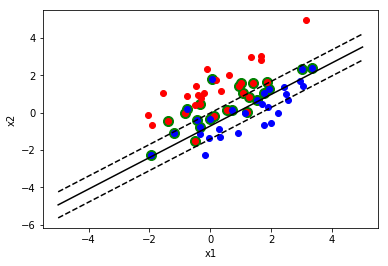

Amended SVM+


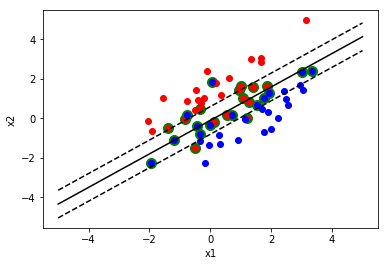

SVM+ amended to have the bias from the SVMd+ and alpha constrained


(None, None, None, None)

In [55]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmpA_clf), print("Amended SVM+"), plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmpAA_clf), print("SVM+ amended to have the bias from the SVMd+ and alpha constrained")

# All the Classifiers

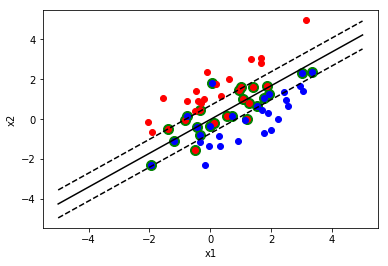

SVM


(None, None)

In [56]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svm_clf), print("SVM")

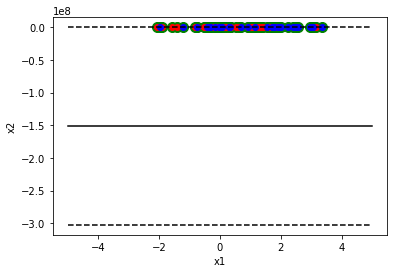

SVM+


(None, None)

In [57]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmp_clf), print("SVM+")

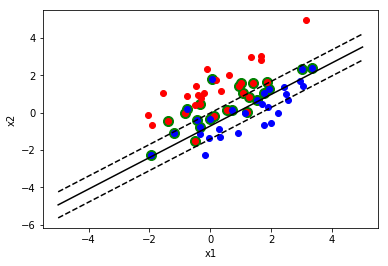

Amended SVM+ (alpha constr.)


(None, None)

In [58]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmpA_clf), print("Amended SVM+ (alpha constr.)")

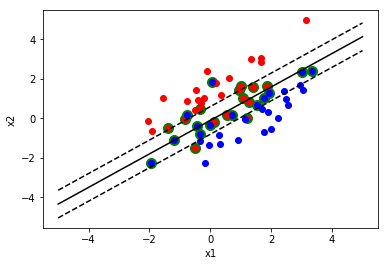

Twice Amended SVM+ (alpha constr. AND bias from SVMd+)


(None, None)

In [ ]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmpAA_clf), print("Twice Amended SVM+ (alpha constr. AND bias from SVMd+)")

In [ ]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdpsa_clf), print("SVM Delta + - Simplified Approach")

In [ ]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdp_clf), print("SVM Delta +")

In [ ]:
plot_margin(prob.X[prob.Y==1], prob.X[prob.Y==-1], svmdpA_clf), print("SVM Delta + with bias from SVM+")

**I think it's clear that I have a problem with my biases. I need to talk about this with somebody cleverer than me.**